In [16]:
# general purpose imports
import os
import sys
import numpy as np
import scipy

# SMRT imports
from smrt import make_snowpack, sensor_list, make_model, open_result, sensitivity_study
from smrt.utils import dB

# DMRT-QMS bindings import
# you can disable DMRT-QMS (long computation) by setting to False
have_dmrtqms = True
# note that to import this binding, you need to install oct2py.
# If not available comment this line and don't execute the cell DMRT-QMS below
if have_dmrtqms:
    from smrt.utils import dmrt_qms_legacy

# Graphics import
%matplotlib notebook
import matplotlib.pyplot as plt
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

In [17]:
## prepare inputs: snowpack with two layers

density = [300]
temperature = [265]
thickness = [200]
stickiness0 = 0.5

radius = np.arange(10, 600, 25)
radius0 = 200

stickiness = np.array([0.1, 0.12, 0.13, 0.14, 0.15, 0.175, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 3, 4, 5, 5.2, 6, 7.5, 10, 20, 30, 50])

snowpacks_radius = sensitivity_study("radius", radius, [make_snowpack(thickness, "sticky_hard_spheres",
                        density=density, temperature=temperature, radius=[r*1e-6], stickiness=stickiness0) for r in radius]) 


snowpacks_stickiness = sensitivity_study("stickiness", stickiness,[make_snowpack(thickness, "sticky_hard_spheres",
                        density=density, temperature=temperature, radius=[radius0*1e-6], stickiness=s) for s in stickiness])


# create the sensor
radiometer = sensor_list.passive(37e9, 55)
radar = sensor_list.active(37e9, 40)

<IPython.core.display.Javascript object>


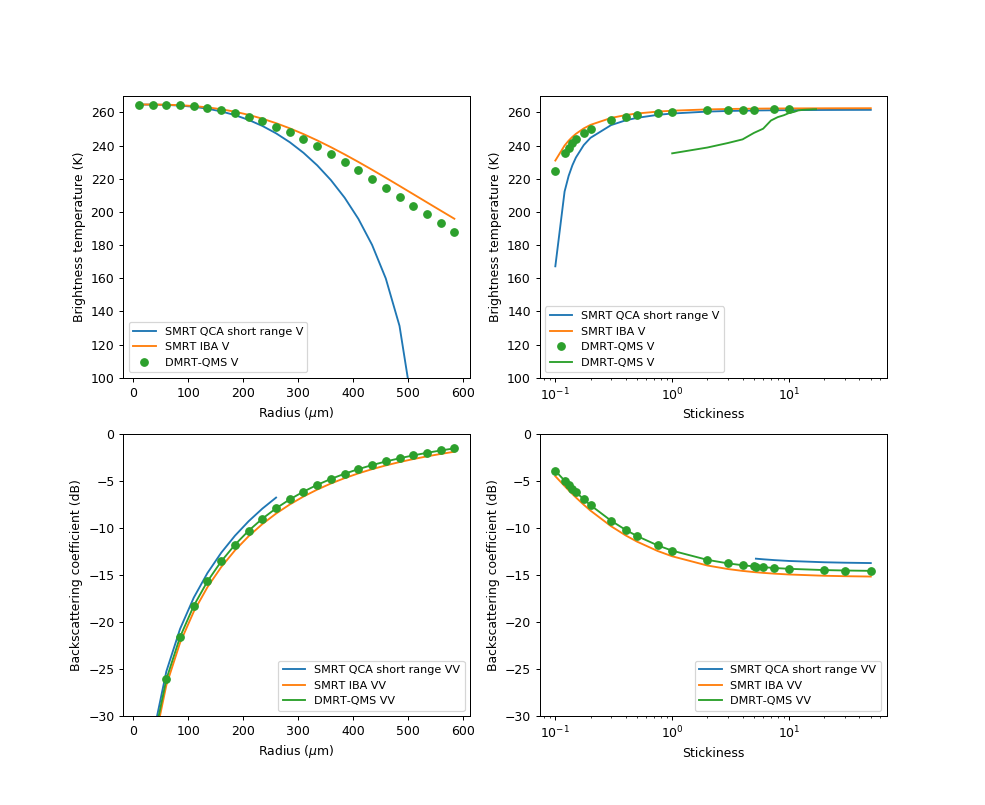

(-30, 0)

In [18]:
# create the SMRT Model with emmodel="dmrt_qca_shortrange"
m_qca = make_model("dmrt_qca_shortrange", "dort")
# run the model
res_qca_radius_p = m_qca.run(radiometer, snowpacks_radius[radius<530])  # [:len(radius_qca)]
res_qca_radius_a = m_qca.run(radar, snowpacks_radius[radius<280])  # [:len(radius_qca)]

# create the SMRT Model with emmodel="iba"
m_iba = make_model("iba", "dort")
# run the model
res_iba_radius_p = m_iba.run(radiometer, snowpacks_radius)
res_iba_radius_a = m_iba.run(radar, snowpacks_radius)

# plots
#f, axs =  plt.subplots(2, 1, figsize=(5.5,9))
f, axs =  plt.subplots(2, 2, figsize=(11,9))
axs[0][0].plot(res_qca_radius_p.coords['radius'], res_qca_radius_p.TbV(), label='SMRT QCA short range V', color=color[0])
axs[0][0].plot(res_iba_radius_p.coords['radius'], res_iba_radius_p.TbV(), label='SMRT IBA V', color=color[1])
axs[0][0].set_xlabel('Radius ($\mu$m)')
axs[0][0].set_ylabel ('Brightness temperature (K)')
axs[0][0].legend(loc='best')
axs[0][0].set_ylim((100, 270))

axs[1][0].plot(res_qca_radius_a.coords['radius'], dB(res_qca_radius_a.sigmaVV()), label='SMRT QCA short range VV', color=color[0])
axs[1][0].plot(res_iba_radius_a.coords['radius'], dB(res_iba_radius_a.sigmaVV()), label='SMRT IBA VV', color=color[1])
axs[1][0].set_xlabel('Radius ($\mu$m)')
axs[1][0].set_ylabel('Backscattering coefficient (dB)')
axs[1][0].legend(loc='best')
axs[1][0].set_ylim((-30, 0))

res_qca_stickiness_p = m_qca.run(radiometer, snowpacks_stickiness)
res_iba_stickiness_p = m_iba.run(radiometer, snowpacks_stickiness)
res_qca_stickiness_a = m_qca.run(radar, snowpacks_stickiness[stickiness>5])
res_iba_stickiness_a = m_iba.run(radar, snowpacks_stickiness)

# plots
axs[0][1].semilogx(res_qca_stickiness_p.coords['stickiness'], res_qca_stickiness_p.TbV(), label='SMRT QCA short range V', color=color[0])
axs[0][1].semilogx(res_iba_stickiness_p.coords['stickiness'], res_iba_stickiness_p.TbV(), label='SMRT IBA V', color=color[1])

axs[0][1].set_xlabel('Stickiness')
axs[0][1].set_ylabel('Brightness temperature (K)')
axs[0][1].legend(loc='best')
axs[0][1].set_ylim((100, 270))

axs[1][1].semilogx(res_qca_stickiness_a.coords['stickiness'], dB(res_qca_stickiness_a.sigmaVV()), label='SMRT QCA short range VV', color=color[0])
axs[1][1].semilogx(res_iba_stickiness_a.coords['stickiness'], dB(res_iba_stickiness_a.sigmaVV()), label='SMRT IBA VV', color=color[1])

axs[1][1].set_xlabel('Stickiness')
axs[1][1].set_ylabel('Backscattering coefficient (dB)')
axs[1][1].legend(loc='best')
axs[1][1].set_ylim((-30, 0))



In [19]:
# run DMRT-QMS in passive mode
cache_file = "res_qms_radius_sensitivity.nc"

if os.path.exists(cache_file):
    res_qms = open_result(cache_file)
    
elif have_dmrtqms:
    res_qms = dmrt_qms_legacy.run(radiometer, snowpacks_radius)
    
    res_qms.save(cache_file)
else:
    res_qms = None

if res_qms:
    axs[0][0].plot(radius, res_qms.TbV(), label='DMRT-QMS V', color=color[2])


def get_limit(res_x, res_ref, threshold):
    err = abs(res_x.TbV()-res_ref.TbV())>threshold
    return np.argmax(err) if any(err) else -1
    

print("1K error: ", radius[get_limit(res_qca_radius_p, res_qms, 1)])
print("5K error: ", radius[get_limit(res_qca_radius_p, res_qms, 5)])

print("1K error: ", radius[get_limit(res_iba_radius_p, res_qms, 1)])
print("5K error: ", radius[get_limit(res_iba_radius_p, res_qms, 5)])




1K error:  185
5K error:  285
1K error:  210
5K error:  410


In [23]:
cache_file = "res_qms_stickiness_sensitivity.nc"

if os.path.exists(cache_file):
    res_qms = open_result(cache_file)
    
elif have_dmrtqms:
    res_qms = dmrt_qms_legacy.run(radiometer, snowpacks_stickiness)
    
    res_qms.save(cache_file)
else:
    res_qms = None

if res_qms:
    axs[0][1].plot(res_qms.coords['stickiness'], res_qms.TbV(), 'o', label='DMRT-QMS V', color=color[2])
    
def get_limit(res_x, res_ref, threshold):
    err = np.array(abs(res_x.TbV()-res_ref.TbV())>threshold)
    err = np.flip(err, 0)
    return -np.argmax(err) if any(err) else -1
    
    
print("1K error: ", stickiness[get_limit(res_qca_stickiness_p, res_qms, 1)])
print("5K error: ", stickiness[get_limit(res_qca_stickiness_p, res_qms, 5)])

print("1K error: ", stickiness[get_limit(res_iba_stickiness_p, res_qms, 1)])
print("5K error: ", stickiness[get_limit(res_iba_stickiness_p, res_qms, 5)])

1K error:  5.2
5K error:  2.0
1K error:  5.0
5K error:  0.2


In [24]:
#DMRT QMS in Active model (Henning's simulation done in matlab)

dmrt_qms_radius = [10, 35, 60, 85, 110, 135, 160, 185, 210, 235, 260, 285, 310, 335, 360, 385, 410, 435, 460, 485, 510, 535, 560, 585]
dmrt_qms_sigma_vv = [-49.3974, -33.0782, -26.0668, -21.5537, -18.2384, -15.6376, -13.5188, -11.7519, -10.2564, -8.9781, -7.8779, -6.9264, -6.1001, -5.3799, -4.75, -4.1971, -3.7099, -3.2789, -2.8961, -2.5548, -2.2491, -1.9743, -1.7263, -1.5015]

axs[1][0].plot(dmrt_qms_radius, dmrt_qms_sigma_vv, label='DMRT-QMS VV', color=color[2])

dmrt_qms_stickiness = [0.1, 0.12, 0.13, 0.14, 0.15, 0.175, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 3, 4, 5, 5.2, 6, 7.5, 10, 20, 30, 50]
dmrt_qms_sigma_vv = [-3.8808, -4.9318, -5.3793, -5.782, -6.146, -6.9191, -7.5436, -9.1972, -10.1711, -10.826, -11.8167, -12.3817, -13.3586, -13.7317, -13.9299, -14.0531, -14.0724, -14.1372, -14.2228, -14.3102, -14.4446, -14.4903, -14.5273]

axs[1][1].plot(dmrt_qms_stickiness, dmrt_qms_sigma_vv, label='DMRT-QMS VV', color=color[2])


In [22]:
#for ax in axs:
#    for a in ax:
#        a.legend(loc='best', prop={'size': 9})
axs[0][0].legend(loc='lower left', prop={'size': 9})
axs[1][0].legend(loc='lower right', prop={'size': 9})
axs[0][1].legend(loc='lower left', prop={'size': 9})
axs[1][1].legend(loc='lower right', prop={'size': 9})
f.savefig("fig_smrt_short_range_limitation.pdf")